<a href="https://colab.research.google.com/github/ErayImamoglu/LSTM-Glove/blob/main/Glove_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os
import matplotlib.pyplot as plt
import time

df=pd.read_csv("/content/train_set_cost_related-_2_.csv")

# Get indices of rows with label 0 and label 1
indices_0 = df[df['CostRelated'] == 0].index
indices_1 = df[df['CostRelated'] == 1].index

# Randomly sample the required number of indices with label 0
random_indices_0 = np.random.choice(indices_0, len(indices_1), replace=False)

# Combine the indices
under_sample_indices = np.concatenate([indices_1, random_indices_0])

# Create the undersampled DataFrame
under_sampled_df = df.loc[under_sample_indices]

# Shuffle the resulting DataFrame for good measure
under_sampled_df = under_sampled_df.sample(frac=1).reset_index(drop=True)

under_sampled_df["CostRelated"] = under_sampled_df["CostRelated"].astype(int)

df=under_sampled_df

df["Text"][1]

'Furthermore, the consultant will review Tender Documents in consultation of available specific reports and documents.'

In [ ]:
#preprocessing
import re
import string

def remove_punct(Text): #punctuationları kaldırmak için bir formül
  translator=str.maketrans("", "", string.punctuation)
  return Text.translate(translator)

df["Text"]=df.Text.map(remove_punct)

df["Text"][1]

'Furthermore the consultant will review Tender Documents in consultation of available specific reports and documents'

In [ ]:
#remove stopwords - not kelimesini atılmadan algoritma başarısını karşılaştır.
#pip install ntlk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop=set(stopwords.words("english"))

def remove_stopwords(Text):
  filtered_words=[word.lower() for word in Text.split() if word.lower() not in stop]
  return " ".join(filtered_words)

df["Text"]=df.Text.map(remove_stopwords) # bu olay çıkarıyor

df["Text"][1]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


'furthermore consultant review tender documents consultation available specific reports documents'

In [ ]:
#split dataset into training and validation set
train_size=int(df.shape[0]*0.8)

train_df=df[:train_size]
val_df=df[train_size:]

#split text and labels
train_sentences=train_df.Text.to_numpy()
train_labels=train_df.CostRelated.to_numpy()
val_sentences=val_df.Text.to_numpy()
val_labels=val_df.CostRelated.to_numpy()

print(len(train_sentences))
print(len(val_sentences))

294
74


In [ ]:
from collections import Counter

def counter_word(text_col):
  count = Counter()
  for text in text_col.values:
    for word in text.split():
      count[word] += 1
  return count

counter = counter_word(df.Text)
num_unique_words = len(counter)

print(num_unique_words)

1791


In [ ]:
!wget https://nlp.stanford.edu/data/glove.6B.zip

In [ ]:
!unzip glove.6B.zip

In [ ]:
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from keras.layers import Dense

# Tokenize only the training set
tokenizer = Tokenizer(num_words=num_unique_words)
tokenizer.fit_on_texts(train_sentences)  # fit only to training

# Initialize the embedding matrix as zeros
# Build embedding matrix
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, 100))  # Assuming embedding dimension is 100

# Load GloVe embeddings
glove_embeddings = {}
with open("glove.6B.100d.txt", 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_embeddings[word] = vector

# Build the embedding matrix
for word, i in tokenizer.word_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [ ]:
train_sequences=tokenizer.texts_to_sequences(train_sentences) #sentences to sequence-indices
val_sequences=tokenizer.texts_to_sequences(val_sentences)     #sentences to sequence-indices

print(train_sentences[1])
print(train_sequences[1])

furthermore consultant review tender documents consultation available specific reports documents
[684, 1, 22, 430, 31, 685, 312, 431, 62, 31]


In [ ]:
#pad the sequences to have the same length
from tensorflow.keras.preprocessing.sequence import pad_sequences

#Max number of words in a sequence
max_length =32

train_padded=pad_sequences(train_sequences,maxlen=max_length,padding="post",truncating="post")
val_padded=pad_sequences(val_sequences,maxlen=max_length,padding="post",truncating="post")

print(train_padded[1])

[684   1  22 430  31 685 312 431  62  31   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


In [ ]:
#check reversing the indices
#flip (key, value)
reverse_word_index = dict([(idx, word) for (word, idx) in tokenizer.word_index.items()])

def decode(sequence):
  return " ".join([reverse_word_index.get(idx, "?") for idx in sequence])

print(reverse_word_index)

{1: 'consultant', 2: 'shall', 3: 'contract', 4: 'works', 5: 'staff', 6: 'design', 7: 'contractor', 8: 'provide', 9: 'office', 10: 'site', 11: 'client', 12: 'supervision', 13: 'project', 14: 'services', 15: 'construction', 16: 'including', 17: 'equipment', 18: 'provided', 19: 'costs', 20: 'required', 21: 'ensure', 22: 'review', 23: 'experts', 24: 'necessary', 25: 'support', 26: 'insurance', 27: 'engineer', 28: 'period', 29: 'local', 30: 'relevant', 31: 'documents', 32: 'liability', 33: 'months', 34: 'must', 35: 'completion', 36: 'etc', 37: 'vehicles', 38: 'accommodation', 39: 'terms', 40: 'implementation', 41: 'cost', 42: 'may', 43: 'consultant’s', 44: 'employer', 45: 'assignment', 46: 'road', 47: 'accordance', 48: 'payment', 49: 'work', 50: 'provision', 51: 'requirements', 52: 'part', 53: 'conditions', 54: 'facilities', 55: 'defects', 56: 'technical', 57: 'report', 58: 'included', 59: 'professional', 60: 'related', 61: 'within', 62: 'reports', 63: 'appropriate', 64: 'duration', 65: 'ke

In [ ]:
# Modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional

In [ ]:
# LSTM Model
from keras.regularizers import l2
# Define Parameter
n_lstm = 64
drop_lstm = 0.2
reg_lambda = 0.01  # regularization factor

# Define LSTM Model
model_LSTM = Sequential()
model_LSTM.add(Embedding(input_dim=vocab_size,
                         output_dim=100,
                         input_length=max_length,
                         weights=[embedding_matrix],
                         trainable=True))
model_LSTM.add(SpatialDropout1D(drop_lstm))
model_LSTM.add(LSTM(n_lstm, return_sequences=False, kernel_regularizer=l2(reg_lambda)))  # Added regularization here
model_LSTM.add(Dropout(drop_lstm))
model_LSTM.add(layers.Dense(1, activation="sigmoid", kernel_regularizer=l2(reg_lambda)))  # Added regularization here


In [ ]:
model_LSTM.summary()

In [ ]:
model_LSTM.compile(loss='binary_crossentropy',
                   optimizer=keras.optimizers.Adam(learning_rate=0.001),
                   metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
num_epochs_LSTM=10
early_stop = EarlyStopping(monitor='val_loss', patience=4)
history_LSTM = model_LSTM.fit(train_padded,
                              train_labels,
                              epochs=num_epochs_LSTM,
                              validation_data=(val_padded, val_labels),
                              callbacks=[early_stop],
                              verbose=2)

Epoch 1/10
10/10 - 7s - loss: 2.0174 - accuracy: 0.4796 - val_loss: 1.8507 - val_accuracy: 0.5946 - 7s/epoch - 738ms/step
Epoch 2/10
10/10 - 1s - loss: 1.7397 - accuracy: 0.5918 - val_loss: 1.6054 - val_accuracy: 0.5946 - 1s/epoch - 145ms/step
Epoch 3/10
10/10 - 1s - loss: 1.5047 - accuracy: 0.6156 - val_loss: 1.3835 - val_accuracy: 0.6081 - 960ms/epoch - 96ms/step
Epoch 4/10
10/10 - 1s - loss: 1.2285 - accuracy: 0.7619 - val_loss: 0.9979 - val_accuracy: 0.8649 - 1s/epoch - 123ms/step
Epoch 5/10
10/10 - 1s - loss: 1.0755 - accuracy: 0.7857 - val_loss: 1.0612 - val_accuracy: 0.7432 - 1s/epoch - 110ms/step
Epoch 6/10
10/10 - 1s - loss: 0.8792 - accuracy: 0.8571 - val_loss: 0.9251 - val_accuracy: 0.7973 - 931ms/epoch - 93ms/step
Epoch 7/10
10/10 - 1s - loss: 0.9203 - accuracy: 0.7891 - val_loss: 0.9375 - val_accuracy: 0.7297 - 1s/epoch - 100ms/step
Epoch 8/10
10/10 - 1s - loss: 0.8405 - accuracy: 0.8129 - val_loss: 0.6978 - val_accuracy: 0.8919 - 1s/epoch - 104ms/step
Epoch 9/10
10/10 - 1

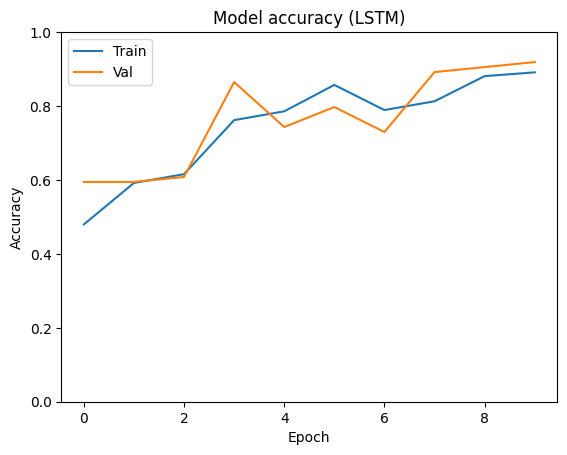

In [ ]:
plt.plot(history_LSTM.history["accuracy"])
plt.plot(history_LSTM.history["val_accuracy"])

plt.title('Model accuracy (LSTM)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.ylim([0, 1])  # Set the y-axis limits

plt.show()

3/3 [==============================] - 2s 15ms/step
Validation Accuracy: 0.918918918918919
Validation Precision: 0.8888888888888888
Validation F1 Score: 0.9142857142857143
Confusion Matrix: 
[[36  4]
 [ 2 32]]


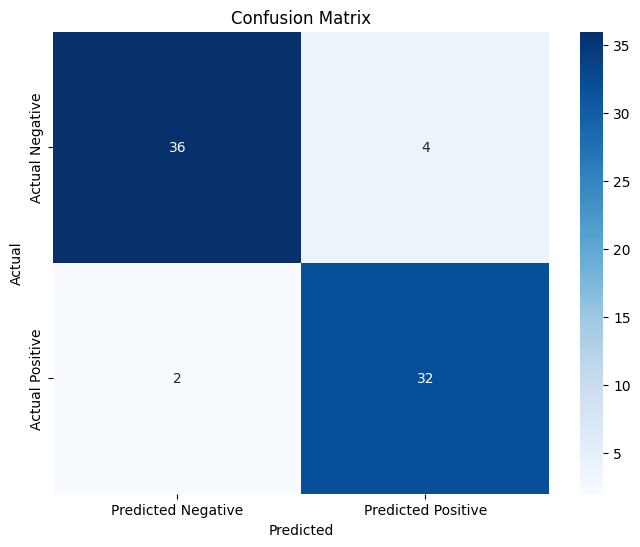

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions on the validation set
val_predictions = model_LSTM.predict(val_padded)
val_predictions = [1 if p > 0.5 else 0 for p in val_predictions]

# Calculate Accuracy
accuracy = accuracy_score(val_labels, val_predictions)

# Calculate Precision
precision = precision_score(val_labels, val_predictions)

# Calculate F1 Score
f1 = f1_score(val_labels, val_predictions)

# Generate Confusion Matrix
conf_matrix = confusion_matrix(val_labels, val_predictions)

print(f"Validation Accuracy: {accuracy}")
print(f"Validation Precision: {precision}")
print(f"Validation F1 Score: {f1}")
print(f"Confusion Matrix: \n{conf_matrix}")

# Plotting the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
